In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [5]:
train_dataset[0][0].max()

tensor(1.)

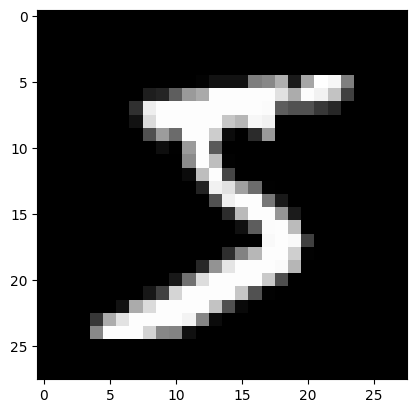

In [6]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0), cmap="gray")

In [7]:
### https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1

class DDPM(nn.Module):
    def __init__(self,
                 model,
                 n_steps=200,
                 min_beta=10 ** -4,
                 max_beta=0.02,
                 device=None,
                 image_chw=(1, 28, 28),) -> None:
        super(DDPM, self).__init__()
        
        self.model = model
        self.n_steps = n_steps
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.device = device
        self.image_chw = image_chw
        
        self.beta_list = (
            torch
            .linspace(self.min_beta,
                      self.max_beta,
                      self.n_steps,)
            .to(self.device)
        )
        
        self.alpha_list = 1 - self.beta_list
        self.alpha_bar_list = (
            torch
            .cumprod(self.alpha_list, dim=0)
            .to(self.device)
        )
        
    def forward_proc(self, x0, t, eta):
        n, c, h, w = x0.shape
        alpha_bar_t = self.alpha_bar_list[t]
        
        noisy = (
            alpha_bar_t.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - alpha_bar_t).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy
    
    def backward_proc(self, x, condition_mask, t, n):
        x_prev = self.model(x, condition_mask, t, n)
        return x_prev
    
    def get_condition_mask(self, labels, drop_prob=0.3, num_classes=10):

        onehot_labels = (
            torch
            .nn
            .functional
            .one_hot(labels, num_classes=num_classes)
            .type(torch.float)
            .to(device)
        )
        condition_mask = (
            torch
            .bernoulli(torch.zeros_like(labels)+drop_prob)
            .to(device)
        )

        condition_mask = condition_mask[:, None]
        condition_mask = condition_mask.repeat(1, num_classes)
        condition_mask = (-1 * (1 - condition_mask))  # -1 or 0
        condition_mask = onehot_labels * condition_mask
        return condition_mask

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(ConvBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out


In [9]:
class DiffusionModel(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, n_classes=10):
        super(DiffusionModel, self).__init__()
        
                # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = self.sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
                
        # First half
        self.te1 = self.make_embedding(time_emb_dim, 1)
        self.ce1 = self.make_embedding(n_classes, 1)
        self.b1 = nn.Sequential(
            ConvBlock((1, 28, 28), 1, 10),
            ConvBlock((10, 28, 28), 10, 10),
            ConvBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self.make_embedding(time_emb_dim, 10)
        self.ce2 = self.make_embedding(n_classes, 10)
        self.b2 = nn.Sequential(
            ConvBlock((10, 14, 14), 10, 20),
            ConvBlock((20, 14, 14), 20, 20),
            ConvBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self.make_embedding(time_emb_dim, 20)
        self.ce3 = self.make_embedding(n_classes, 20)
        self.b3 = nn.Sequential(
            ConvBlock((20, 7, 7), 20, 40),
            ConvBlock((40, 7, 7), 40, 40),
            ConvBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )
        # Bottleneck
        self.te_mid = self.make_embedding(time_emb_dim, 40)
        self.ce_mid = self.make_embedding(n_classes, 40)
        self.b_mid = nn.Sequential(
            ConvBlock((40, 3, 3), 40, 20),
            ConvBlock((20, 3, 3), 20, 20),
            ConvBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self.make_embedding(time_emb_dim, 80)
        self.ce4 = self.make_embedding(n_classes, 80)
        self.b4 = nn.Sequential(
            ConvBlock((80, 7, 7), 80, 40),
            ConvBlock((40, 7, 7), 40, 20),
            ConvBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self.make_embedding(time_emb_dim, 40)
        self.ce5 = self.make_embedding(n_classes, 40)
        self.b5 = nn.Sequential(
            ConvBlock((40, 14, 14), 40, 20),
            ConvBlock((20, 14, 14), 20, 10),
            ConvBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self.make_embedding(time_emb_dim, 20)
        self.ce_out = self.make_embedding(n_classes, 20)
        self.b_out = nn.Sequential(
            ConvBlock((20, 28, 28), 20, 10),
            ConvBlock((10, 28, 28), 10, 10),
            ConvBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, condition_mask, t, n):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        c = condition_mask
        unsqz = lambda x: x.unsqueeze(-1).unsqueeze(-1)
        
        out1 = self.b1(x)  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2))  # (N, 40, 7, 7)

        
        
        out_mid = self.b_mid(unsqz(self.ce_mid(c)) * self.down3(out3) + unsqz(self.te_mid(t)))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(unsqz(self.ce4(c)) * out4 + unsqz(self.te4(t)))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(unsqz(self.ce5(c)) * out5 + unsqz(self.te5(t)))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(unsqz(self.ce_out(c)) * out + unsqz(self.te_out(t)))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out
    def sinusoidal_embedding(self, n, d):
        # Returns the standard positional embedding
        embedding = torch.zeros(n, d)
        wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
        wk = wk.reshape((1, d))
        t = torch.arange(n).reshape((n, 1))
        embedding[:,::2] = torch.sin(t * wk[:,::2])
        embedding[:,1::2] = torch.cos(t * wk[:,::2])

        return embedding
    
    def make_embedding(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [10]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
model = DiffusionModel(n_steps).to(device)
ddpm = DDPM(
    model=model,
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

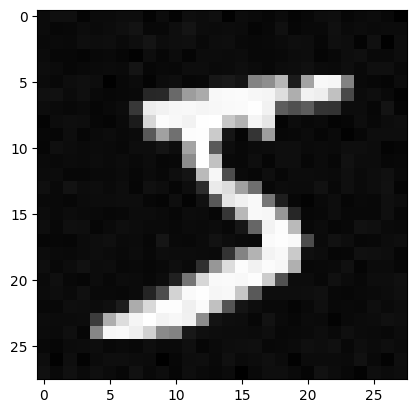

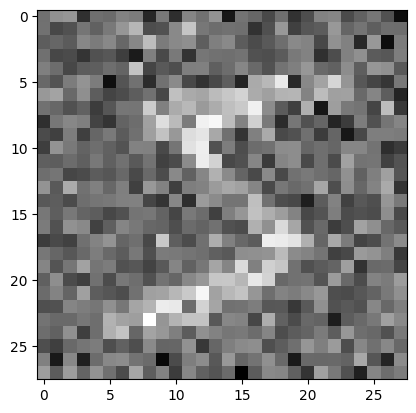

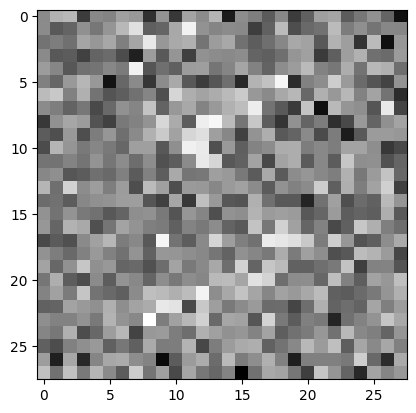

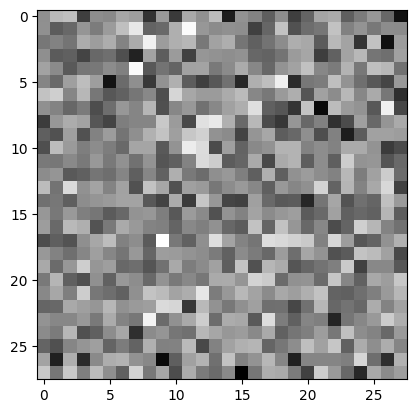

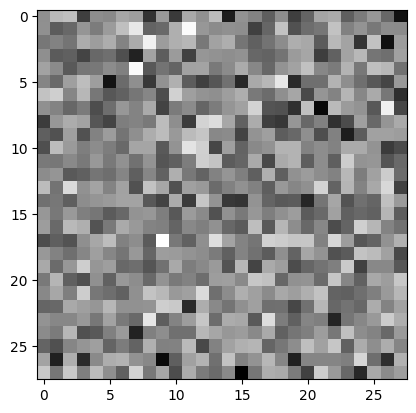

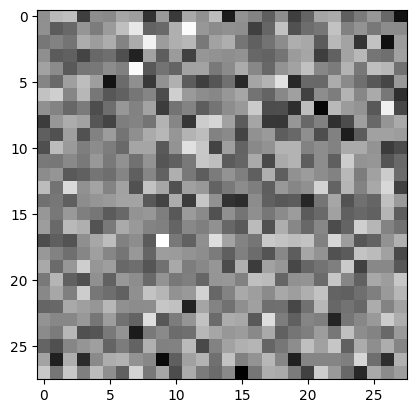

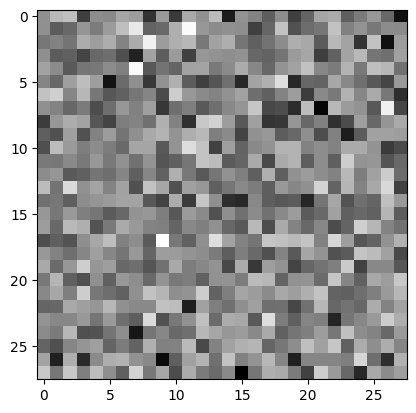

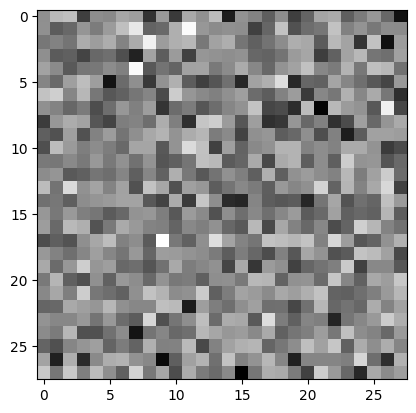

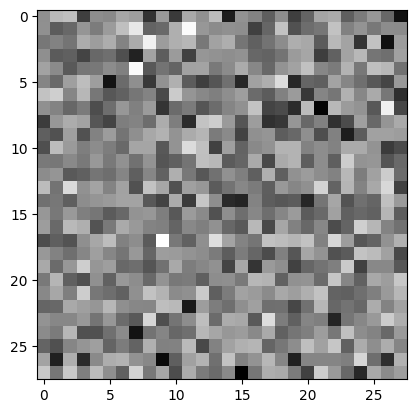

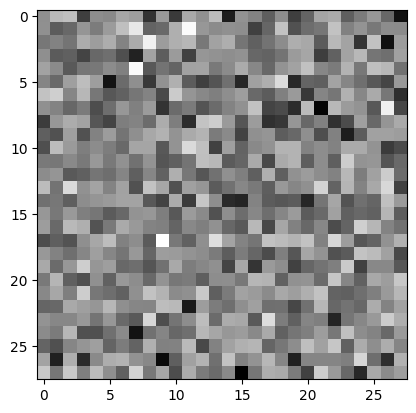

In [11]:
images = train_dataset[0][0].reshape(-1, 1, 28, 28).to(device)
noise = torch.randn_like(images).to(device)
for i in [1,111,222,333,444,555,666,777,888,999]:
    noisy = ddpm.forward_proc(images, i, noise)
    plt.imshow(noisy[0].permute(1, 2, 0).cpu(), cmap="gray")
    plt.show()

Epoch 0, Batch 234, Loss: 0.0891021117568016


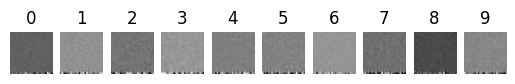

Epoch 1, Batch 234, Loss: 0.07616223394870758


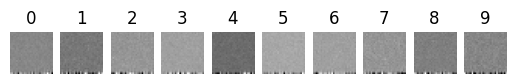

Epoch 2, Batch 234, Loss: 0.069850854575634


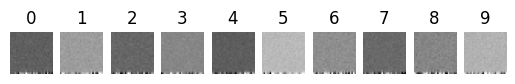

Epoch 3, Batch 234, Loss: 0.06337093561887741


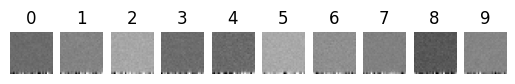

Epoch 4, Batch 234, Loss: 0.06149045377969742


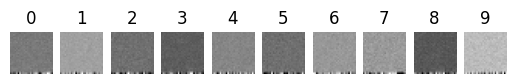

Epoch 5, Batch 234, Loss: 0.04212776571512222


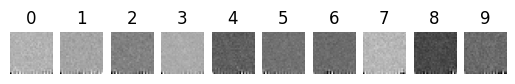

Epoch 6, Batch 234, Loss: 0.02387532778084278


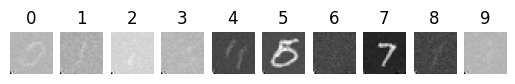

Epoch 7, Batch 234, Loss: 0.024279285222291946


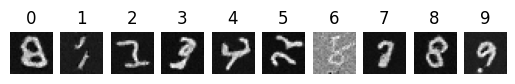

Epoch 8, Batch 234, Loss: 0.020443430170416832


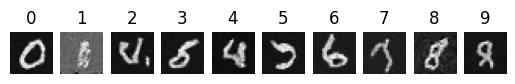

Epoch 9, Batch 234, Loss: 0.022587060928344727


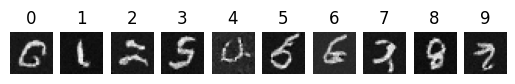

Epoch 10, Batch 234, Loss: 0.02311050333082676


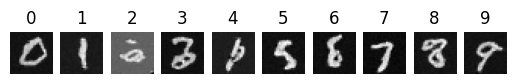

Epoch 11, Batch 234, Loss: 0.018641004338860512


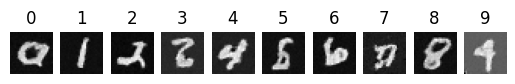

Epoch 12, Batch 234, Loss: 0.01679692603647709


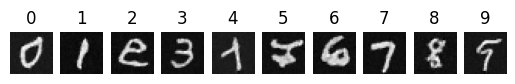

Epoch 13, Batch 234, Loss: 0.025278298184275627


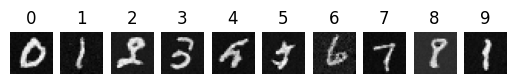

Epoch 14, Batch 234, Loss: 0.020337209105491638


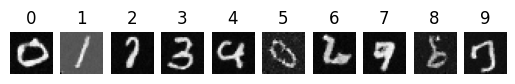

Epoch 15, Batch 234, Loss: 0.020942963659763336


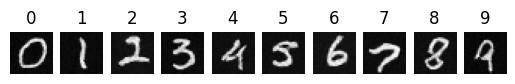

Epoch 16, Batch 234, Loss: 0.02229859121143818


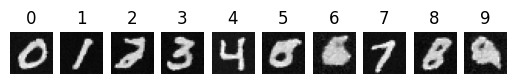

Epoch 17, Batch 234, Loss: 0.013468935154378414


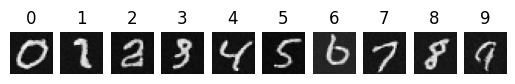

Epoch 18, Batch 234, Loss: 0.01821773685514927


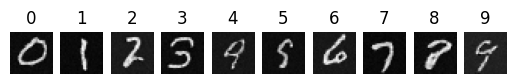

Epoch 19, Batch 234, Loss: 0.019738856703042984


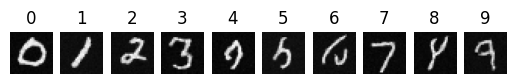

In [12]:
samples = torch.randn(10, 1, 28, 28).to(device)


num_epochs = 20
            
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        batch_size = images.shape[0]
        t = torch.randint(1, n_steps-1, (batch_size,), device=device, dtype=torch.long)
        
        noise = torch.randn_like(images).to(device)
        noisy = ddpm.forward_proc(images, t, noise)
        condition_mask = ddpm.get_condition_mask(labels, drop_prob=0.3, num_classes=10)
        outputs = ddpm.backward_proc(noisy, condition_mask, t, batch_size)
        
        
        loss = criterion(noise, outputs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")
    
    with torch.no_grad():
        labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        x_t = copy.deepcopy(samples)
        for t in range(n_steps-1, 0, -1):
            t_tensor = torch.tensor([t for _ in range(samples.shape[0])]).to(device)
            condition_mask = ddpm.get_condition_mask(labels, drop_prob=0.0, num_classes=10)
            pred = ddpm.backward_proc(x_t, condition_mask, t_tensor, samples.shape[0])
            noise = torch.randn_like(samples).to(device)

            beta_t = ddpm.beta_list[t]
            alpha_t = ddpm.alpha_list[t]
            alpha_bar_t = ddpm.alpha_bar_list[t]
            alpha_bar_t_prev = ddpm.alpha_bar_list[t-1]
            
            x_t = x_t - (1-alpha_t) / (1e-6 + (1-alpha_bar_t).sqrt()) * pred
            x_t = (1 / (1e-6 + alpha_t.sqrt())) * x_t
            
            std = torch.sqrt(beta_t*(1-alpha_bar_t_prev)/(1-alpha_bar_t))
            
            x_t = x_t + std * noise
            
        
        fig, axs = plt.subplots(1, 10)
        normalized = x_t.clone()
        for i in range(len(normalized)):
            normalized[i] -= torch.min(normalized[i])
            normalized[i] *= 255 / torch.max(normalized[i])
            axs[i].imshow((normalized[i]).permute(1, 2, 0).cpu().detach().numpy(),cmap="gray")
            axs[i].set_axis_off()
            axs[i].set_title(i)
        plt.show()
    
        
    
    
